<a href="https://colab.research.google.com/github/thienan99dt/sentiment140/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/content/drive')


Found GPU at: /device:GPU:0


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
    random_image_cpu = tf.random_normal((100, 100, 100, 3))
    net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
    net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
    random_image_gpu = tf.random_normal((100, 100, 100, 3))
    net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
    net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
    sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
    print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise

def cpu():
    sess.run(net_cpu)

def gpu():
    sess.run(net_gpu)
  
    #Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.358751644999984
GPU (s):
2.272169720999983
GPU speedup over CPU: 1x


In [0]:
#!pip3 install gensim

In [0]:
import re
import pandas as pd
from time import sleep
from matplotlib import pyplot as plt
from gensim.models import Word2Vec,KeyedVectors

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, Flatten, Dropout,MaxPooling1D, GlobalAveragePooling1D

from keras.utils import plot_model
from keras import optimizers

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 


# You will have to download the set of stop words the first time
#import nltk
#nltk.download('stopwords')

PATH = '/content/drive/My Drive/sentiment'
PATH_DATASET = PATH + '/dataset'
PATH_PRETRAIN = PATH + '/pretrained'
PATH_IMG = PATH + '/img'

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [0]:
PATH_DATASET

'/content/drive/My Drive/sentiment/dataset'

In [0]:
df = pd.read_csv(PATH_DATASET + '/my_clean.csv', index_col = 0)
df.dropna(inplace = True)
df.reset_index(drop=True,inplace=True)
print(df.describe())
print(df.info())
#1596753

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


        polarity
count  1600000.0
mean         0.5
std          0.5
min          0.0
25%          0.0
50%          0.5
75%          1.0
max          1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
polarity    1600000 non-null int64
data        1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


In [0]:
X = df[df.columns[1]]
y = df[df.columns[0]]

In [0]:
len(X)

1600000

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

modelW2V = KeyedVectors.load_word2vec_format(PATH_PRETRAIN + '/GoogleNews-vectors-negative300.bin',
                                                 binary=True, limit=30000)
#print(modelW2V)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(modelW2V.wv.vocab)+1, EMBEDDING_DIM))
word2index = {}
embedding_matrix[0]=np.zeros( EMBEDDING_DIM)
for i in range(len(modelW2V.wv.vocab)):
    embedding_vector = modelW2V.wv[modelW2V.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i+1] = embedding_vector
        word2index[modelW2V.wv.index2word[i]] = i+1
vocab = modelW2V.wv.vocab

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by 

In [0]:
# create a weight matrix for words in training docs
vocab_size = len(vocab)
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [0]:
#Convert data to number matrix to use trained embeddings matrix
output_matrix = []
for d in X:
    indices = []
    for w in d.split():
        if w in vocab:
            indices.append(word2index[re.sub(r'[^\w\s]','',w).lower()])
    output_matrix.append(indices)

In [0]:
print("Length of vocabulary: {v}\nShape of Embedd: {em}".format(v = len(vocab), em = embedding_matrix.shape))

Length of vocabulary: 30000
Shape of Embedd: (30001, 300)


In [0]:
y.shape

(1600000,)

In [0]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

MAX_SEQUENCE_LENGTH = len(max(output_matrix,key=len))
print(MAX_SEQUENCE_LENGTH)
encoder = LabelBinarizer()
data_pad = pad_sequences(output_matrix, maxlen=MAX_SEQUENCE_LENGTH)
y = encoder.fit_transform(y)

40


In [0]:
X, y = data_pad, y

In [0]:
len(data_pad)

1600000

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

In [0]:
print(X_train.shape)
print(y_train.shape)

(1280000, 40)
(1280000, 1)


In [0]:
num_classes = len(np.unique(y))
print(num_classes)

2


In [0]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint
#mc = ModelCheckpoint(PATH+'/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=embedding_matrix.shape[1], 
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], 
                    trainable=False))

model.add(Convolution1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(4))
model.add(Convolution1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(3))
#model.add(Convolution1D(32, 3, activation='relu', padding='same'))
#model.add(MaxPooling1D(2))
model.add(Flatten())
#model.add(GlobalAveragePooling1D())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=4096,verbose=1)
# evaluate the model

Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 37s 29us/step - loss: 0.4846 - acc: 0.7672 - val_loss: 0.4485 - val_acc: 0.7882
Epoch 2/5
1280000/1280000 [==============================] - 37s 29us/step - loss: 0.4338 - acc: 0.7990 - val_loss: 0.4308 - val_acc: 0.7988
Epoch 3/5
1280000/1280000 [==============================] - 37s 29us/step - loss: 0.4193 - acc: 0.8072 - val_loss: 0.4237 - val_acc: 0.8043
Epoch 4/5
1280000/1280000 [==============================] - 37s 29us/step - loss: 0.4098 - acc: 0.8127 - val_loss: 0.4212 - val_acc: 0.8057
Epoch 5/5
1280000/1280000 [==============================] - 37s 29us/step - loss: 0.4036 - acc: 0.8160 - val_loss: 0.4197 - val_acc: 0.8065
CPU times: user 1min 20s, sys: 43 s, total: 2min 3s
Wall time: 3min 6s


In [0]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(X_train)
print("Report for trainning")
print(classification_report(y_train, y_pred, digits = 5))
print("Report for test")
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, digits = 5))
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
#0.80673

Report for trainning
              precision    recall  f1-score   support

           0    0.83565   0.79795   0.81637    640506
           1    0.80638   0.84282   0.82420    639494

    accuracy                        0.82037   1280000
   macro avg    0.82102   0.82038   0.82028   1280000
weighted avg    0.82103   0.82037   0.82028   1280000

Report for test
              precision    recall  f1-score   support

           0    0.81946   0.78205   0.80032    159494
           1    0.79282   0.82879   0.81041    160506

    accuracy                        0.80549    320000
   macro avg    0.80614   0.80542   0.80536    320000
weighted avg    0.80610   0.80549   0.80538    320000

320000/320000 [==============================] - 30s 94us/step
Train: 0.820, Test: 0.805


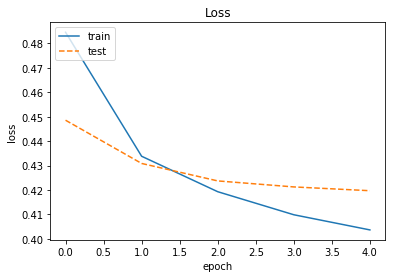

In [0]:
plt.title('Loss')
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], '--',label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(PATH_IMG+ '/loss_1.png')
plt.show()


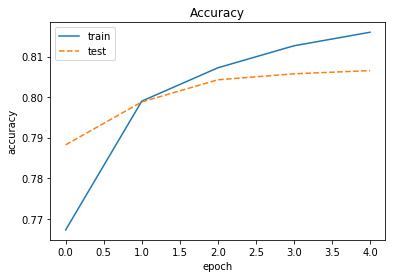

In [0]:
plt.title('Accuracy')
plt.plot(model.history.history['acc'], label='train')
plt.plot(model.history.history['val_acc'], '--',label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(PATH_IMG+ '/acC_1.png')
plt.show()

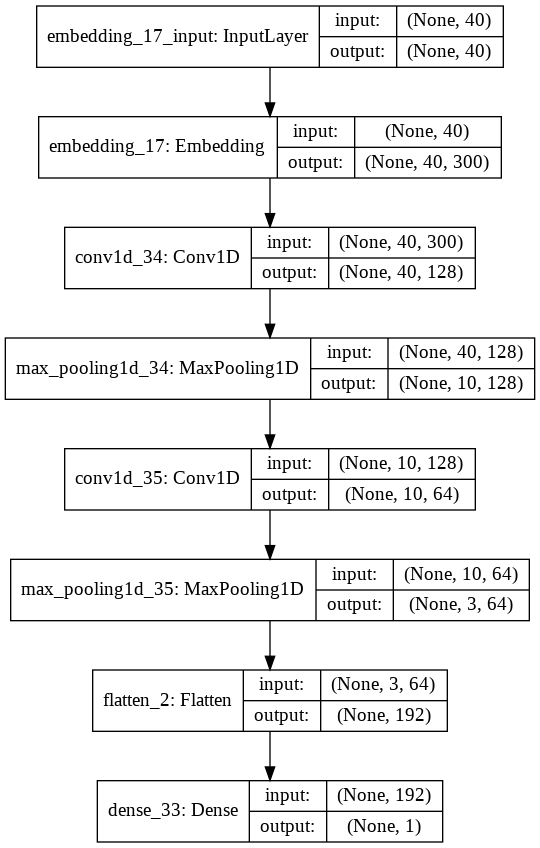

In [0]:
plot_model(model, to_file=PATH_IMG+'/model.png',show_shapes=True, show_layer_names=True)


In [0]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 40, 300)           9000300   
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 40, 128)           115328    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 10, 64)            24640     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

# Saving Model

In [0]:
model.save_weights(PATH + "/final_model.h5")